# Анализ гипотез для увеличения выручки интернет-магазина

Имеется список гипотез для увеличения выручки, подготовленный совместо с отделом маркетинга. 

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Описание данных

Датасет `hypothesis`
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Датасет `orders`
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Датасет `visitors`
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


## Предобработка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# чтение файлов
try: 
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    )

In [3]:
display(hypothesis.head(3))
display(orders.head(3))
visitors.head(3)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


Для дальнейшего удобства переименуем столбцы в датасетах `hypothesis` и `orders`

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId': 'transaction_id',
                                'visitorId': 'visitor_id'})

In [5]:
for dataset in [hypothesis, orders, visitors]:
    dataset.info()
    print()
    print('Количество дубликатов:', dataset.duplicated().sum())
    print('Количество пропущенных значений:', dataset.isna().sum().sum())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Количество дубликатов: 0
Количество пропущенных значений: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Количество дубликатов: 0
Количество п

Необходимо перевести данные о дате в датасетах `orders` и `visitors` в формат даты

In [6]:
orders.date = pd.to_datetime(orders.date)
visitors.date = pd.to_datetime(visitors.date)

На данном этапе:
* привели названия столбцов к более удобному виду
* проверили данные на наличие дубликатов - обнаружено не было
* проверили данные на наличие пропущенных значений - обнаружено не было
* проверили типы данных и привели даты к соответствующему типу

Таким образом, данные в удобном и правильном формате для дальнейшей работы.

## Приоритизация гипотез

### Фреймворк `ICE`

In [7]:
pd.set_option('display.max_colwidth', None) # задаем полное отображение текста в ячейках
pd.set_option('display.float_format', '{:.2f}'.format) # отображение только двух цифр после запятой

In [8]:
# считаем ICE
hypothesis['ICE'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False).reset_index()

,index,hypothesis,ICE
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по методу `ICE`:
* запуск акции со скидкой на день рождения
* добавление двух новых каналов привлечения трафика, позволяющих привлекать на 30% больше пользователей
* добавление формы подписки на все основные страницы для собирания базы клиентов для email рассылок

### Фреймворк `RICE`

In [9]:
hypothesis['RICE'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False).reset_index()

,index,hypothesis,RICE
0,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
1,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
2,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
4,8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
5,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
6,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
7,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [10]:
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values('RICE', ascending=False).style.background_gradient()

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


С учетом параметра `reach` (количество пользователей, которых затронет изменение) видим несколько иную картину. Наиболее перспективная гипотеза по `ICE` про акцию на день рождения в данном случае опускается на пятую позицию, т.к. лишь небольшая часть пользователей сможет воспользоваться данным предложением (день рождения только один раз в год у каждого пользователя). Самой перспективной становится гипотеза о добавлении формы подписки на все основные страницы для собирания базы клиентов и email рассылок. Данная гипотеза была перспективной и по `ICE`, но с учетом того, что это будет распространятся на всех пользователей, то она становится наиболее перспективной.

В итоге по `RICE` имеем такие наиболее перспективные гипотезы:
* добавление формы подписки на все основные страницы для собирания базы клиентов для email рассылок
* добавление блоков рекомендаций товаров на сайт для повышения конверсии и среднего чека заказа
* добавление двух новых каналов привлечения трафика, позволяющих привлекать на 30% больше пользователей
* показ на главной странице баннеров с актуальными акциями и распродажами для увеличения конверсии

## Анализ A/B-теста

### Кумулятивная выручка по дням и группам

Создадим сразу таблицу со всеми кумулятивными данными.

In [11]:
# массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
# названия столбцов
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [12]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Получили датафрейм `cumulative_data` со столбцами:
* `date` — дата
* `group` — группа A/B-теста (A или B)
* `orders` — кумулятивное количество заказов на указанную дату в указанной группе
* `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе
* `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек)
* `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе

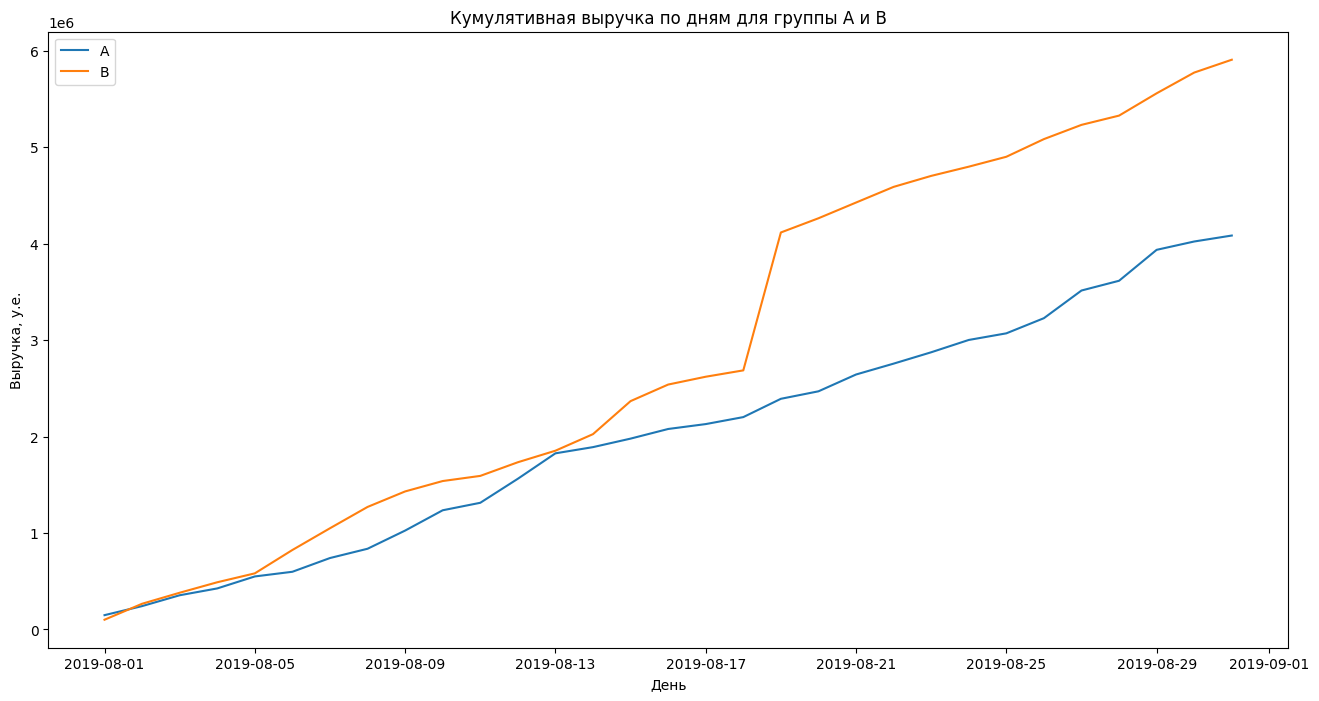

In [13]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data.group == 'A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data.group == 'B'][['date','revenue', 'orders']]

plt.figure(figsize=(16, 8))
# график выручки группы А
plt.plot(cumulative_revenue_a.date, cumulative_revenue_a.revenue, label='A')

# график выручки группы B
plt.plot(cumulative_revenue_b.date, cumulative_revenue_b.revenue, label='B')

plt.legend()
plt.title('Кумулятивная выручка по дням для группы A и B')
plt.xlabel('День')
plt.ylabel('Выручка, у.е.')
plt.show()

In [14]:
# т.к. виден резкий скачок у группы B, посмотрим на максимальную выручку по дням для группы B
orders[orders.group == 'B'].groupby('date').agg({'revenue': 'sum'}).sort_values('revenue', ascending=False).head(3)

,revenue
date,
2019-08-19,1429920
2019-08-15,342499
2019-08-06,242342


Выручка группы `А` почти равномерно увеличивается в течение всего теста. Выручка группы `B` так же увеличивается почти равномерно, однако есть резкий рост 19-го августа 2019 г. В этот день выручка более чем в 4 раза выше, чем в  следующий по выручке день. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. Позже проанализируем чем это вызвано. Также из графика видно, что на протяжении всего теста выручка группы `B` больше выручки группы `А`.

### Кумулятивный средний чек по дням и группам

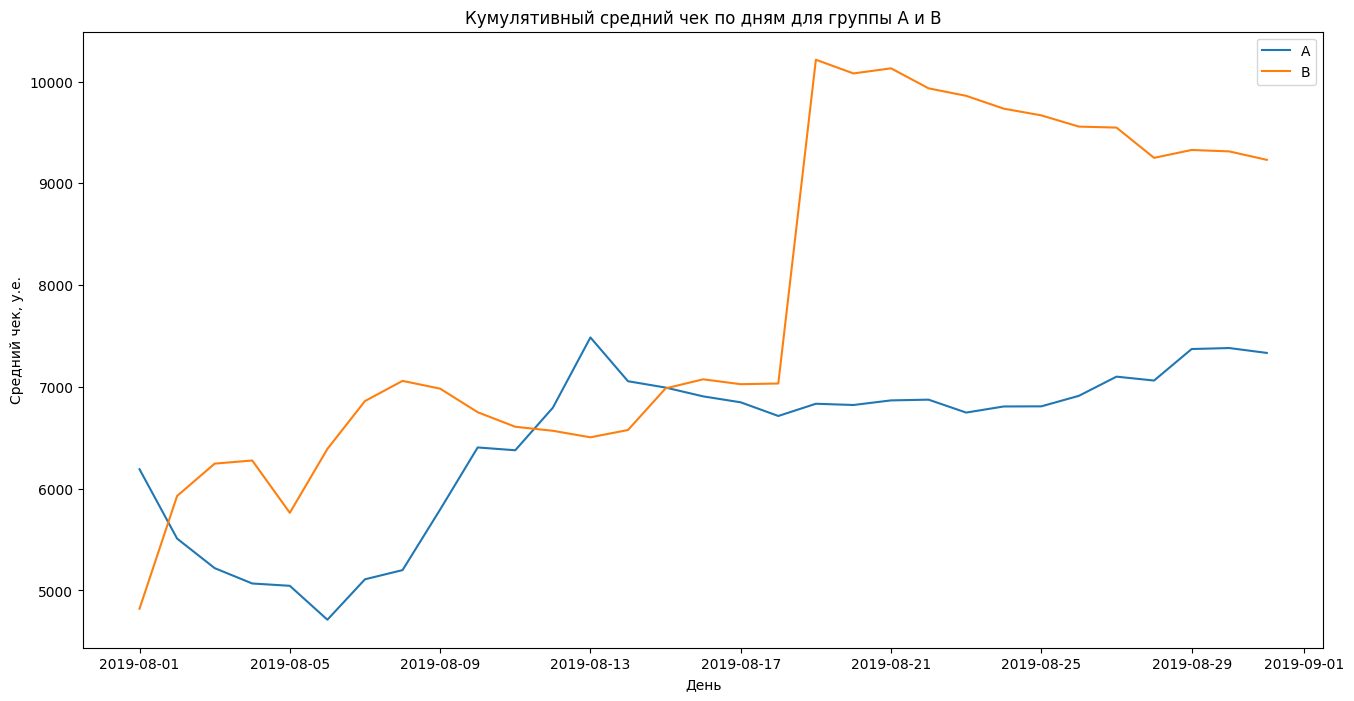

In [15]:
plt.figure(figsize=(16, 8))

# график среднего чека группы А
plt.plot(cumulative_revenue_a.date, cumulative_revenue_a.revenue / cumulative_revenue_a.orders, label='A')

# график среднего чека группы B
plt.plot(cumulative_revenue_b.date, cumulative_revenue_b.revenue / cumulative_revenue_b.orders, label='B')

plt.legend()
plt.title('Кумулятивный средний чек по дням для группы A и B')
plt.xlabel('День')
plt.ylabel('Средний чек, у.е.')
plt.show()

Средний чек группы `B` также резко растет 19-го августа 2019 года, этим и объясняется скачок в графике выручки. Вероятно, в этот день были совершены какие-то крупные заказы. Средний чек становится равномерным ближе к концу теста, как для группы `A`, так и для группы `B`. При этом в целом на протяжении почти всего времени теста средний чек группы `B` выше группы `A`, что может говорить о преимуществе группы `B`.

### Относительное изменение кумулятивного среднего чека группы `B` к группе `A`

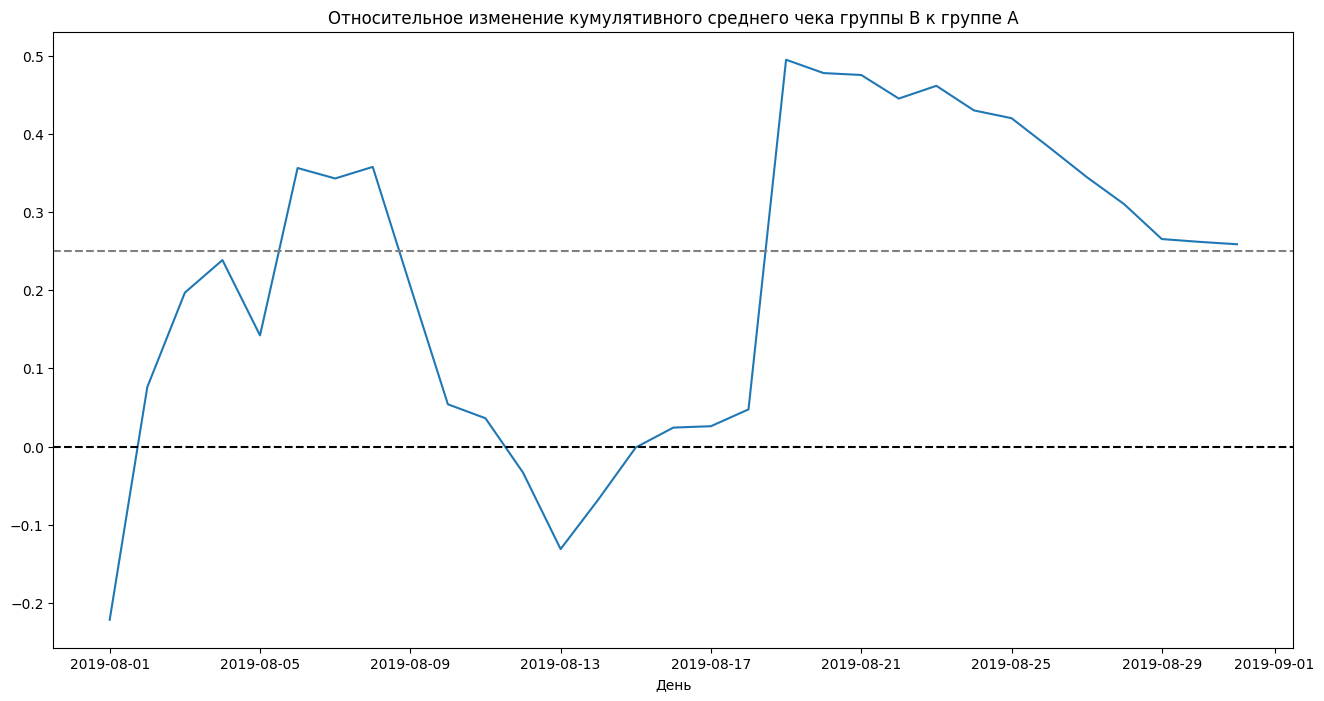

In [16]:
# собираем данные в одном датафрейме
merged_сumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(16, 8))
# cтроим отношение средних чеков
plt.plot(
    merged_сumulative_revenue.date, 
    (merged_сumulative_revenue.revenue_b / merged_сumulative_revenue.orders_b) / 
    (merged_сumulative_revenue.revenue_a / merged_сumulative_revenue.orders_a) 
    - 1 
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('День')

plt.show()

Разница между средними чеками двух групп резко менялась несколько раз, что свидетельствует о наличии аномальных заказов. Также к концу теста видим прирост для группы `B` относительно группы `A` в более чем в `25%`.

###  Кумулятивное среднее количество заказов на посетителя по группам

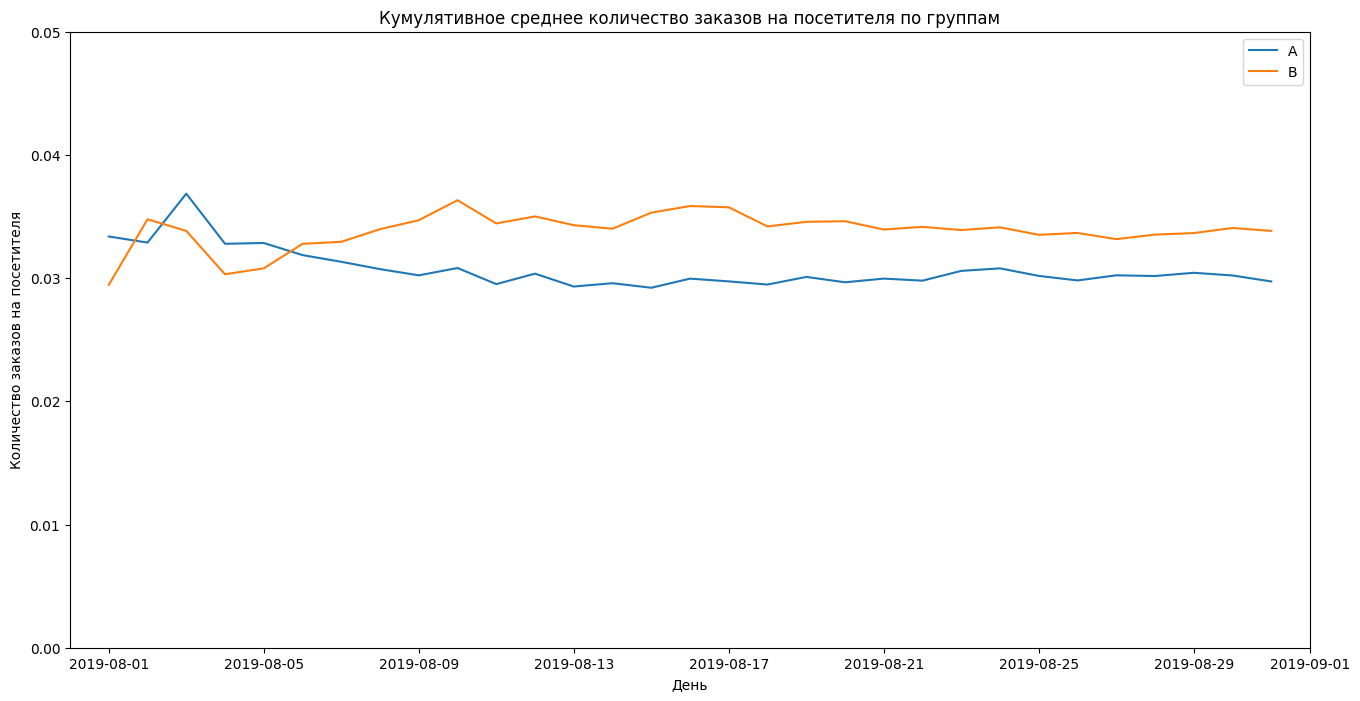

In [17]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data.orders / cumulative_data.visitors

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data.group == 'A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data.group == 'B']

# строим графики
plt.figure(figsize=(16, 8))

plt.plot(cumulative_data_a.date, cumulative_data_a.conversion, label='A')
plt.plot(cumulative_data_b.date, cumulative_data_b.conversion, label='B')

plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('День')
plt.ylabel('Количество заказов на посетителя')
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0, 0.05])
plt.show()

Начиная с 5-го августа конверсия группы `A` зафикисировалась около одного значения. Среднее количество заказов на посетитиля группы `B` также после 5-го августа фиксируется около одного, большего значения, чем для группы `A`. Это также может свидетельствовать об успешности группы `B`.

###  Относительное изменение кумулятивного среднего количества заказов на посетителя группы `B` к группе `A`

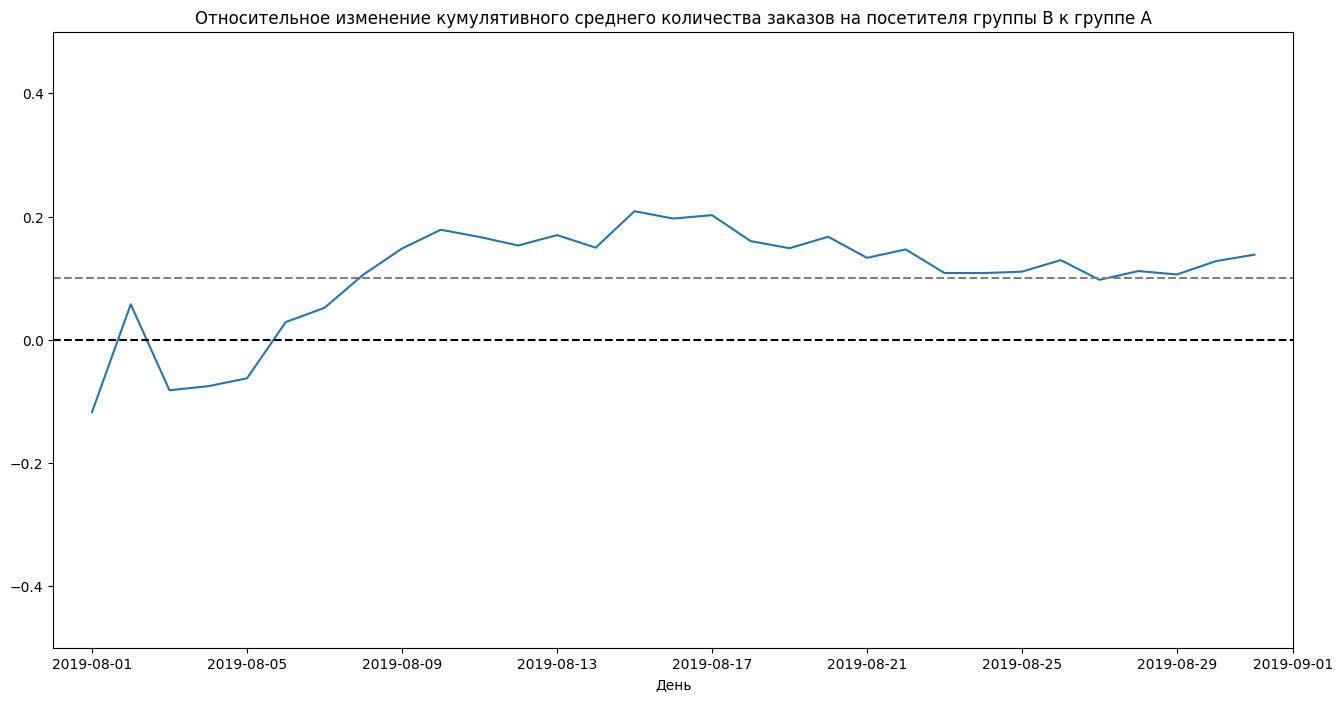

In [18]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(16, 8))

plt.plot(merged_cumulative_conversions.date, 
         merged_cumulative_conversions.conversion_b / merged_cumulative_conversions.conversion_a - 1)


plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('День')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.show()

С 6-го августа группа `B` лидирует по среднему количеству заказов на посетителя. К концу теста конверсия группы `B` зафиксировалась около прироста в `10%` относительно группы `A`, что говорит о преимуществе группы `B`.

### Количество заказов по пользователям

In [19]:
# считаем количество заказов для каждого пользователя
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders_count'})
)
orders_by_users.sort_values('orders_count', ascending=False).head()

,visitor_id,orders_count
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


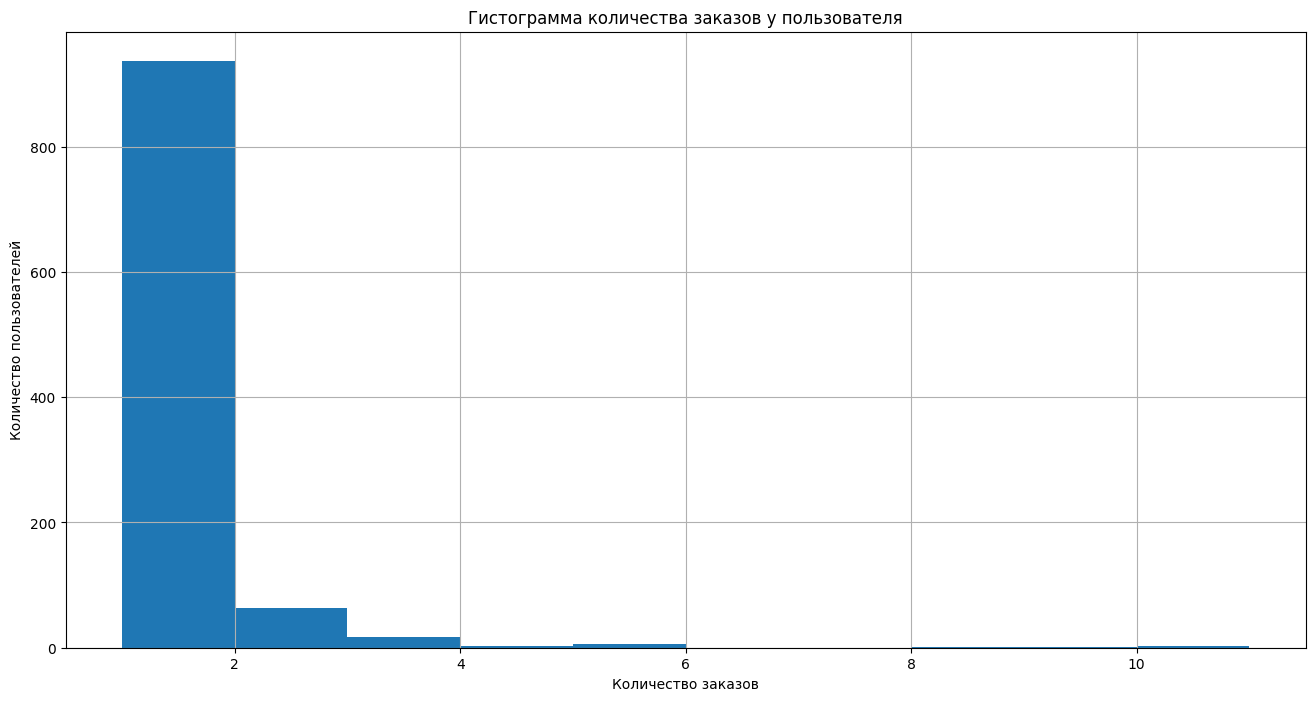

In [20]:
orders_by_users.orders_count.hist(figsize=(16, 8))
plt.title('Гистограмма количества заказов у пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Большинство пользователей совершило только один заказ. Однако, есть и значительня доля пользователей с 2-4 заказами.

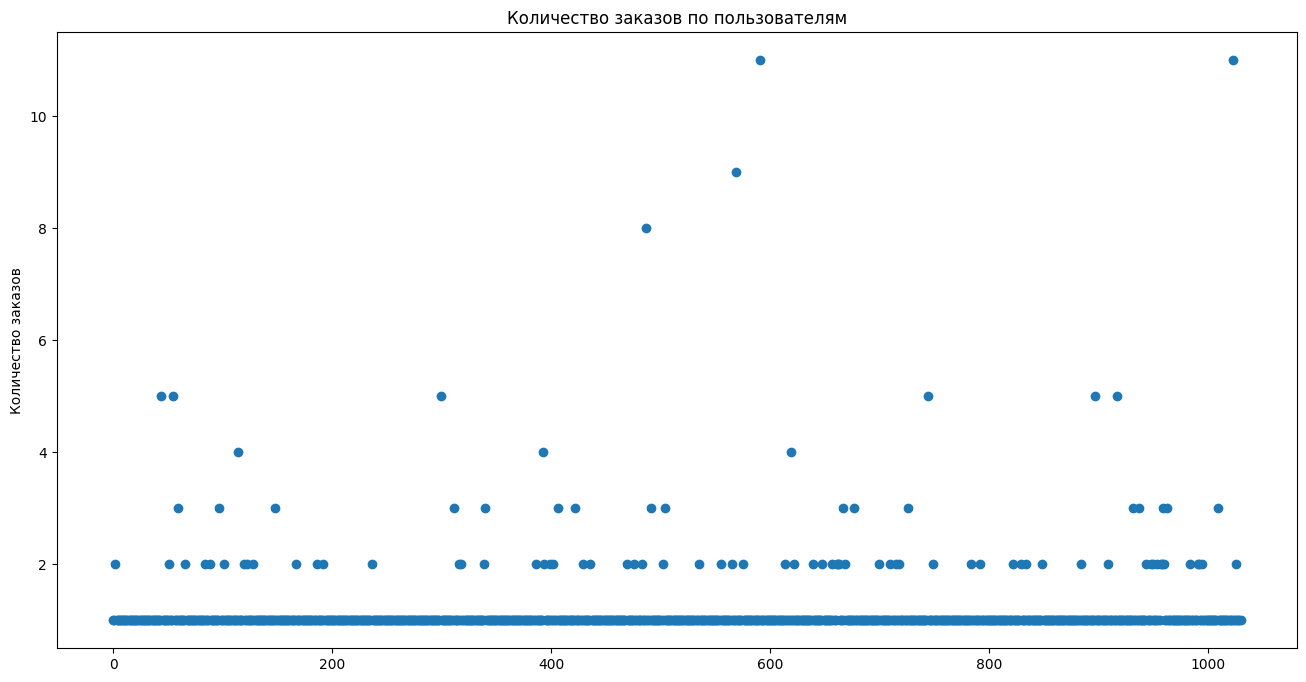

In [21]:
plt.figure(figsize=(16, 8))

plt.scatter(pd.Series(range(0, len(orders_by_users))), 
            orders_by_users.orders_count)

plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

Пока нельзя точно сказать о доле пользователей с двумя заказами, их достаточно много, но непонятно считать их аномалиями или нет. Пользователей с более чем тремя заказами мало, скорее всего их можно будет считать аномальными. Необходимо посчитать перцентили оличества заказов на одного пользователя.

### Перцентили количества заказов на пользователя

In [22]:
print(
    np.percentile(orders_by_users.orders_count, [95, 99])
)

[2. 4.]


Не более `5%` пользователей совершали больше двух заказов. И не более `1%` пользователей - больше четырех заказов. Примите за аномальных пользователей тех, кто совершил `4` заказа и более, тем самым убрав `1%` пользователей.

### Стоимость заказов

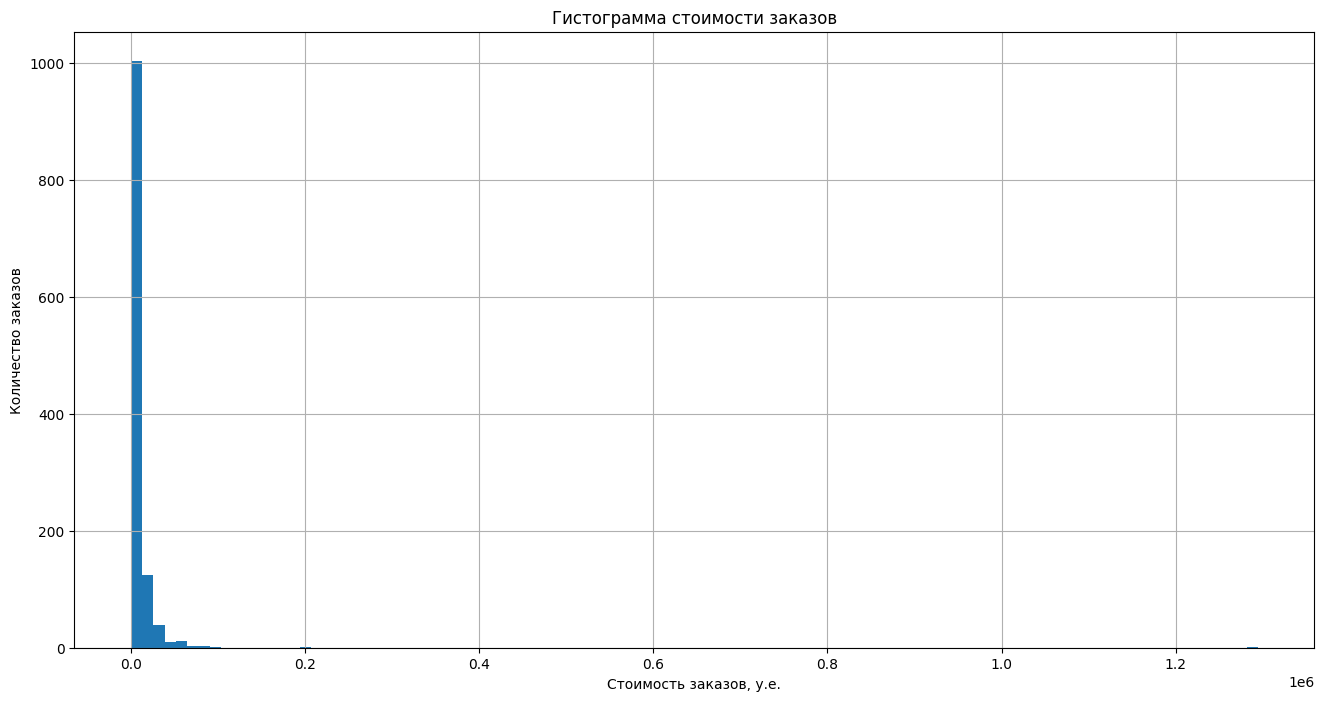

In [23]:
orders.revenue.hist(figsize=(16, 8), bins=100)
plt.title('Гистограмма стоимости заказов')
plt.xlabel('Стоимость заказов, у.е.')
plt.ylabel('Количество заказов')
plt.show()

In [24]:
orders.sort_values('revenue', ascending=False).head()

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


Большинство заказов меньше 50000 у.е., однако есть и сверх дорогие заказы, из-за которых также не получается оценить распределение более дешевых заказов.

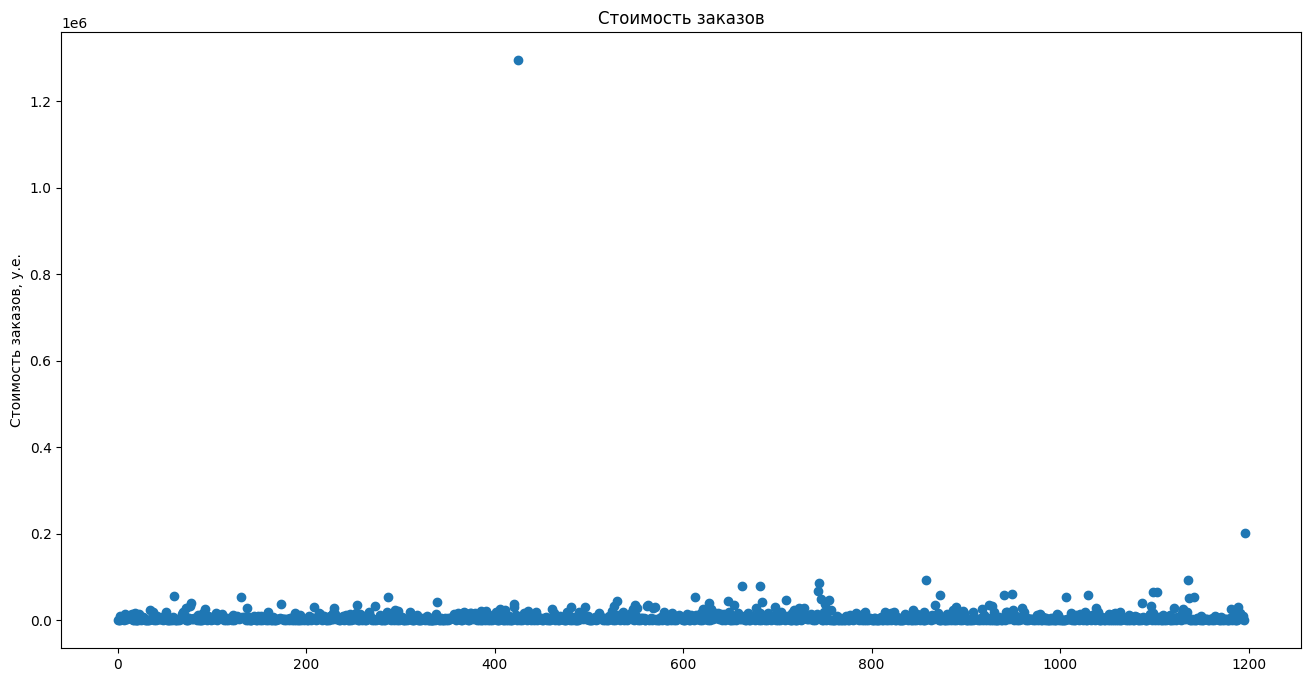

In [25]:
plt.figure(figsize=(16, 8))
plt.scatter(pd.Series(range(0, len(orders.revenue))), 
            orders.revenue)
plt.title('Стоимость заказов')
plt.ylabel('Стоимость заказов, у.е.')
plt.show()

Видим один сверхприбыльный заказ и еще несколько также аномально дорогих заказов. Большинство заказов невысокой стоимостью, но в таком виде их сложно оценить, посмотрим с другим масштабом.

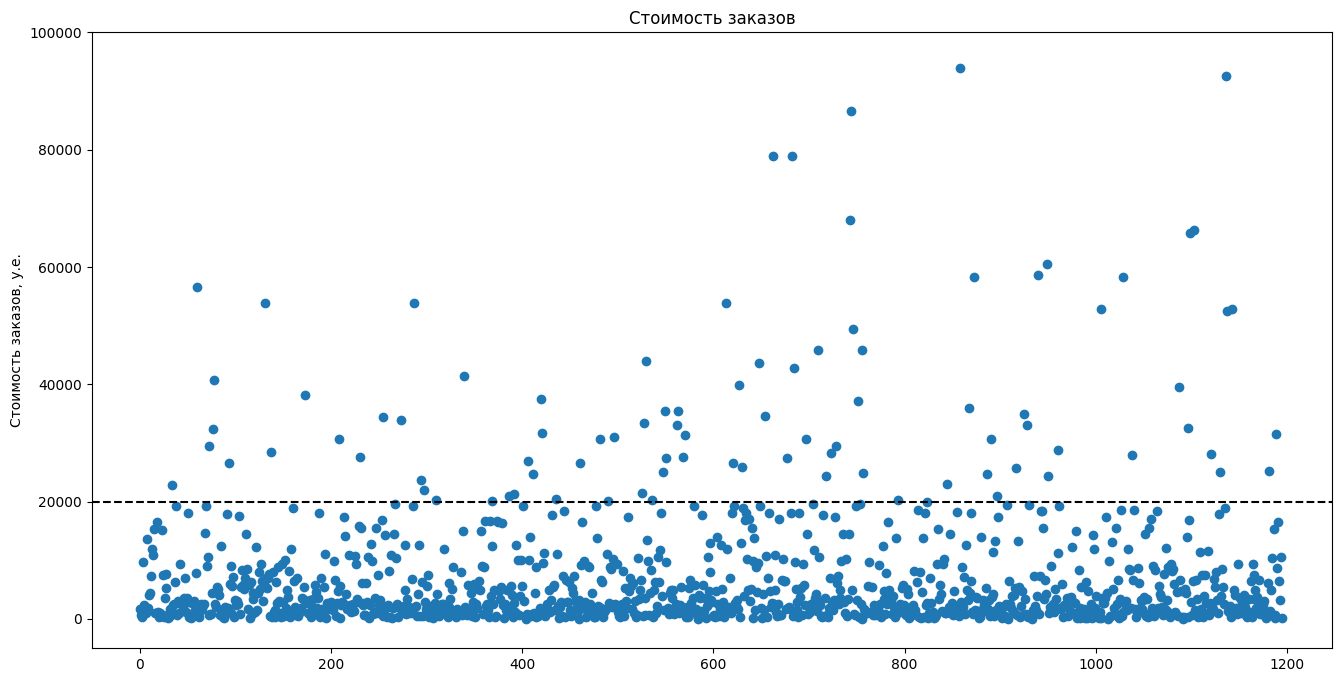

In [26]:
plt.figure(figsize=(16, 8))
plt.scatter(pd.Series(range(0, len(orders.revenue))), 
            orders.revenue)
plt.title('Стоимость заказов')
plt.ylabel('Стоимость заказов, у.е.')
plt.axhline(y=20000, color='black', linestyle='--')
plt.axis([-50, len(orders.revenue) + 50, -5000, 100000])
plt.show()

Большинство заказов стоимостью меньше 20000 у.е., но, чтобы оценить долю более дорогих заказов и принять решение об аномальности, необходимо будет посмотреть на перцентили.

### Перцентили стоимости заказов

In [27]:
print(
    np.percentile(orders.revenue, [95, 99])
)

[28000.  58233.2]


Не более, чем у `5%` заказов стоимость выше `28000` у.е., и не более, чем у `1%` заказов - дороже `58233` у.е. Возьмем за верхнюю границу стоимость заказа в `30000` у.е. - так мы уберем от `1%` до `5%` заказов c наибольшей стоимостью.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. 

**Нулевая**: различий в среднем количестве заказов между группами нет. 

**Альтернативная**: различия в среднем между группами есть.

Соберем данные в таблицу `data`.

In [28]:
# количество посетителей группы А по дням
visitors_a_daily = visitors[visitors.group == 'A'][['date', 'visitors']].rename(
    columns={'visitors': 'visitors_per_date_a'}
)
# количество посетителей группы B по дням
visitors_b_daily = visitors[visitors.group == 'B'][['date', 'visitors']].rename(
    columns={'visitors': 'visitors_per_date_b'}
)

# кумулятивное количество посетителей по дням в группе А
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1
).rename(columns={'visitors_per_date_a': 'visitors_cummulative_a'})
# кумулятивное количество посетителей по дням в группе B
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1
).rename(columns={'visitors_per_date_b': 'visitors_cummulative_b'})

# количество заказов и суммарная выручка по дням в группе А
orders_a_daily = (
    orders[orders.group == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_per_date_a', 'revenue': 'revenue_per_date_a'})
)
# количество заказов и суммарная выручка по дням в группе B
orders_b_daily = (
    orders[orders.group == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_per_date_b', 'revenue': 'revenue_per_date_b'})
)

# кумулятивное количество заказов и выручки по дням в группе А
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).rename(columns={'orders_per_date_a': 'orders_cummulative_a', 'revenue_per_date_a': 'revenue_cummulative_a'})
# кумулятивное количество заказов и выручки по дням в группе B
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).rename(columns={'orders_per_date_b': 'orders_cummulative_b', 'revenue_per_date_b': 'revenue_cummulative_b'})

# соединяем в один датафрейм
data = (
    orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
        .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
        .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
        .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
        .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
        .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
        .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Получили данные в одной таблице `data`:
* `date` — дата;
* `orders_per_date_a` — количество заказов в выбранную дату в группе A;
* `revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;
* `orders_per_date_b` — количество заказов в выбранную дату в группе B;
* `revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;
* `orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;
* `orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;
* `visitors_per_date_a` — количество пользователей в выбранную дату в группе A;
* `visitors_per_date_b` — количество пользователей в выбранную дату в группе B;
* `visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;
* `visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.

In [29]:
# количество заказов пользователя группы А
orders_by_users_a = (
    orders[orders.group == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders_count'})
)
# количество заказов пользователя группы В
orders_by_users_b = (
    orders[orders.group == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders_count'})
)

In [30]:
# соединим пользователей с заказами (указывая их колиечество) с пользователями без заказов (0) для обеих групп

sample_a = pd.concat(
    [
        orders_by_users_a.orders_count,
        pd.Series(
            0,
            index=np.arange(
                data.visitors_per_date_a.sum() - len(orders_by_users_a.orders_count)
            ),
            name='orders'
        ),
    ],
    axis=0
)

sample_b = pd.concat(
    [
        orders_by_users_b.orders_count,
        pd.Series(
            0,
            index=np.arange(
                data.visitors_per_date_b.sum() - len(orders_by_users_b.orders_count)
            ),
            name='orders'
        ),
    ],
    axis=0
)

In [31]:
print('p-value = {0:.4f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительное различие среднего числа заказов между сегментами: {0:.3f}'.format(
    sample_b.mean() / sample_a.mean() - 1)
)

p-value = 0.0168
Относительное различие среднего числа заказов между сегментами: 0.138


Получили `p-value = 0.0168`, что меньше `0.05`. Значит, отвергаем нулевую гипотезу, принимаем альтернативную. По «сырым» данным в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего числа заказов группы `B` к группе `A` равен `13.8%`.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза**: различий в среднем чеке между группами нет. 

**Альтернативная гипотеза**: различия в среднем чеке между группами есть. 

In [32]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(orders[orders.group == 'A']['revenue'], orders[orders.group == 'B']['revenue'])[1])
)

print(
    'Относительное различие среднего чека между сегментами: {0:.3f}'.format(
        orders[orders.group == 'B']['revenue'].mean() / orders[orders.group == 'A']['revenue'].mean() - 1)
)

p-value = 0.729
Относительное различие среднего чека между сегментами: 0.259


`p-value = 0.729`, что больше `0.05` - нет причин отвергать нулевую гипотезу, статистически значимых отличий в среднем чеке между группами нет. При этом, средний чек группы `B` превышает средний чек группы `A` на `25.9%`. Вероятно, сказывается влияние сверхдорогих заказов.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Ранее приняли за аномальных пользователей тех, кто совершил от `4` заказов или совершил заказ дороже `30000 у.е.` Так мы убираем `1%` пользователей с наибольшим числом заказов и от `1%` до `5%` пользователей с дорогими заказами.


   
**Нулевая гипотеза**: различий в среднем количестве заказов (с отфильтрованными данными без аномалий) на посетителя между группами нет. 

**Альтернативная гипотеза**: различия в среднем количестве заказов (с отфильтрованными данными без аномалий) на посетителя между группами есть.

In [33]:
# пользователи с большим количеством заказов
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a.orders_count >= 4]['visitor_id'],
        orders_by_users_b[orders_by_users_b.orders_count >= 4]['visitor_id'],
    ],
    axis=0
)
# пользователи с дорогими заказами
users_with_expensive_orders = orders[orders.revenue > 30000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head())
abnormal_users.shape[0]

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitor_id, dtype: int64

57

In [34]:
round(abnormal_users.shape[0] / orders.visitor_id.nunique() * 100, 2)

5.53

Таким образом, получили 57 аномальных пользователей, что составляет 5.53% от всего количества пользователей, совершивших хотя бы один заказ.

In [35]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders_count'],
        pd.Series(
            0,
            index=np.arange(
                data.visitors_per_date_a.sum() - len(orders_by_users_a.orders_count)
            ),
            name='orders'
        ),
    ],
    axis=0
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders_count'],
        pd.Series(
            0,
            index=np.arange(
                data.visitors_per_date_b.sum() - len(orders_by_users_b.orders_count)
            ),
            name='orders'
        ),
    ],
    axis=0
)

In [36]:
print('p-value = {0:.4f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

print('Относительное различие среднего числа заказов между сегментами: {0:.3f}'.format(
    sample_b_filtered.mean() / sample_a_filtered.mean() - 1)
)

p-value = 0.0183
Относительное различие среднего числа заказов между сегментами: 0.148



   
Как и в случае с сырыми данными, статистическая значимость достигнута. При значении p-value в 0.0183 отвергаем нулевую гипотезу и принимаем альтернативную. Среднее количество заказов группы `B` отличается от среднего количества заказов группы `A` даже с учетом аномалий. Сегмент `B` значительно лучше сегмена `A`. Аномалии не повлияли на результаты для среднего количества заказов. Результаты практически не изменились.


### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным


   
**Нулевая гипотеза**: различий в среднем чеке между группами нет (с учетом отфильтрованности данных, без аномалий). 

**Альтернативная гипотеза**: различия в среднем чеке между группами есть (с учетом отфильтрованности данных, без аномалий). 

In [37]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders.group == 'A',
                    np.logical_not(orders.visitor_id.isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders.group == 'B',
                    np.logical_not(orders.visitor_id.isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительное различие среднего чека между сегментами: {0:.3f}".format(
        orders[
            np.logical_and(
                orders.group == 'B',
                np.logical_not(orders.visitor_id.isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders.group == 'A',
                np.logical_not(orders.visitor_id.isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.958
Относительное различие среднего чека между сегментами: -0.020




Значение `p-value = 0.958` значительно выше 0.05, что не позволяет нам отвергнуть нулевую гипотезу. Таким образом, она остается в силе. По отфильтрованным данным, с учетом аномалий, различий в среднем чеке между группами попрежнему нет. Разница относительно результатов с сырыми данными между сегментами сократилась с `25%` до `-2%`. 


### Результаты теста

* Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по сырым данным, так и после фильтрации аномалий.
* Нет статистически значимого различия по среднему чеку между группами ни по сырым, ни по данным после фильтрации аномалий.
* График различия среднего количества заказов между группами сообщает, что результаты группы `B` лучше группы `A` и имеют тенденции к росту.
* График различия среднего чека говорит о том, что результаты группы `B` лучше результатов группы `A`. К концу теста средний чек группы `B` превышает средний чек группы `A` на `25%`. Однако сказывается влияние аномально дорогих заказов.

**Исходя из обнаруженных фактов, тест следует остановить и признать его успешным.**

## Выводы

* Наиболее перспективные гипотезы по фреймвору `RICE`:
 - добавление формы подписки на все основные страницы для собирания базы клиентов для email рассылок
 - добавление блоков рекомендаций товаров на сайт для повышения конверсии и среднего чека заказа
 - добавление двух новых каналов привлечения трафика, позволяющих привлекать на 30% больше пользователей
 - показ на главной странице баннеров с актуальными акциями и распродажами для увеличения конверсии
* На протяжении всего A/B теста выручка группы `B` больше выручки группы `A`. Кумулятивная выручка обоих групп почти равномерно растет в течение теста. Есть резкий рост в группе `B`, вызванный аномально дорогими заказами.
* Средний чек для обоих групп выравнивается к концу теста и выше в группе `B`, однако это влияние аномально дорогих заказов. Статистически значимых различий в средних чеках групп обнаружено не было ни по сырым данным, ни после фильтрации.
* Конверсия группы `B` начиная с 5-го августа выше конверсии группы `A`. Это также подтверждается статистически. Как по сырым, так и по отфильтрованным данным, обнаружено статистически значимое различие количества заказов на посетителя между группами. Результаты группы `B` лучше результатов группы `A` к концу теста более чем на `10%`.
* Большинство пользователей совершило только один заказ. Более двух заказов совершило не более `5%` пользователей.
* Не менее `95%` всех заказов стоимостью менее 28000 у.е. Однако есть несколько сверхдорогих заказов.

**По результатам A/B теста признали победу группы `B` в связи с увеличением среднего количества заказов на посетителя.**